# Stock Movement Clusters

This notebook documents the process of using unsupervised learning to group stocks with similar price movement patterns. The goal is to identify distinct "trend-based" groups within the market to aid in portfolio diversification and investment analysis.

**ML Techniques Used:** Unsupervised Learning, K-Means Clustering, PCA (Principal Component Analysis).

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Data Collection & Preparation

### 2.1 Data Sources

Stock price data was sourced from Yahoo Finance using the `yfinance` library for a selection of tech stocks.

### 2.2 Preprocessing

To make the time-series data comparable, we first handle any missing values. Then, we normalize the data using `StandardScaler`. This ensures that each stock's price series has a mean of 0 and a standard deviation of 1, focusing on the relative movement rather than the absolute price.

In [9]:
# Download data from yfinance
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'BRK-B', 'JPM', 'JNJ',
    'V', 'MA', 'UNH', 'HD', 'PG', 'DIS', 'BAC', 'XOM', 'CVX', 'KO',
    'PEP', 'WMT', 'PFE', 'MRK', 'ABBV', 'T', 'NFLX', 'ADBE', 'CRM', 'INTC',
    'QCOM', 'AVGO', 'AMD', 'NKE', 'COST', 'TMO', 'MDT', 'DHR', 'TXN', 'AMAT',
    'GS', 'MS', 'BK', 'USB', 'SCHW', 'LMT', 'RTX', 'BA', 'GE', 'F',
    'RELIANCE.NS', 'HDFCBANK.NS', 'INFY.NS', 'TCS.NS', 'ICICIBANK.NS', 'LT.NS', 'SBIN.NS', 'HINDUNILVR.NS', 'BAJFINANCE.NS', 'MARUTI.NS',
    'AXISBANK.NS', 'KOTAKBANK.NS', 'BHARTIARTL.NS', 'ITC.NS', 'ASIANPAINT.NS', 'SUNPHARMA.NS', 'ULTRACEMCO.NS', 'TITAN.NS', 'WIPRO.NS', 'TECHM.NS',
    'POWERGRID.NS', 'NTPC.NS', 'ONGC.NS', 'COALINDIA.NS', 'ADANIENT.NS', 'ADANIPORTS.NS', 'GRASIM.NS', 'HCLTECH.NS', 'DIVISLAB.NS', 'DRREDDY.NS',
    'CIPLA.NS', 'SBILIFE.NS', 'HDFCLIFE.NS', 'ICICIPRULI.NS', 'BRITANNIA.NS', 'EICHERMOT.NS', 'HEROMOTOCO.NS', 'BAJAJ-AUTO.NS', 'M&M.NS', 'TATAMOTORS.NS',
    'TATASTEEL.NS', 'JSWSTEEL.NS', 'HAVELLS.NS', 'PIDILITIND.NS', 'DABUR.NS', 'GAIL.NS', 'INDUSINDBK.NS', 'SHREECEM.NS', 'SBICARD.NS'
]



data = yf.download(tickers, start="2022-01-01", end="2025-01-01",auto_adjust=True)['Close']

[*********************100%***********************]  99 of 99 completed


In [10]:
print(type(data))
print(data.index)
print(data.columns)
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex(['2022-01-03', '2022-01-04', '2022-01-05', '2022-01-06',
               '2022-01-07', '2022-01-10', '2022-01-11', '2022-01-12',
               '2022-01-13', '2022-01-14',
               ...
               '2024-12-17', '2024-12-18', '2024-12-19', '2024-12-20',
               '2024-12-23', '2024-12-24', '2024-12-26', '2024-12-27',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', name='Date', length=777, freq=None)
Index(['AAPL', 'ABBV', 'ADANIENT.NS', 'ADANIPORTS.NS', 'ADBE', 'AMAT', 'AMD',
       'AMZN', 'ASIANPAINT.NS', 'AVGO', 'AXISBANK.NS', 'BA', 'BAC',
       'BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'BHARTIARTL.NS', 'BK', 'BRITANNIA.NS',
       'BRK-B', 'CIPLA.NS', 'COALINDIA.NS', 'COST', 'CRM', 'CVX', 'DABUR.NS',
       'DHR', 'DIS', 'DIVISLAB.NS', 'DRREDDY.NS', 'EICHERMOT.NS', 'F',
       'GAIL.NS', 'GE', 'GOOGL', 'GRASIM.NS', 'GS', 'HAVELLS.NS', 'HCLTECH.NS',
       'HD', 'HDFCBANK.NS', 'HDFCLIFE.NS', 

In [11]:
# Check for null values
print("Null values per ticker:")
print(data.isnull().sum())

Null values per ticker:
Ticker
AAPL             24
ABBV             24
ADANIENT.NS      38
ADANIPORTS.NS    38
ADBE             24
                 ..
USB              24
V                24
WIPRO.NS         38
WMT              24
XOM              24
Length: 99, dtype: int64


In [12]:
# Handle missing values (forward fill)
data.ffill(inplace=True)

# Display first 5 rows of dataset
print(data.head())

Ticker            AAPL        ABBV  ADANIENT.NS  ADANIPORTS.NS        ADBE  \
Date                                                                         
2022-01-03  178.443100  117.621170  1713.995361     720.039673  564.369995   
2022-01-04  176.178406  117.395348  1715.841797     722.630066  554.000000   
2022-01-05  171.492065  118.012016  1712.298340     737.928345  514.429993   
2022-01-06  168.629303  117.456131  1709.952759     723.167725  514.119995   
2022-01-07  168.795959  117.152153  1695.978516     719.550964  510.700012   

Ticker            AMAT         AMD        AMZN  ASIANPAINT.NS       AVGO  ...  \
Date                                                                      ...   
2022-01-03  154.547241  150.240005  170.404495    3301.070557  61.667759  ...   
2022-01-04  153.030106  144.419998  167.522003    3336.662842  62.374317  ...   
2022-01-05  148.565598  136.149994  164.356995    3401.769775  59.778652  ...   
2022-01-06  151.078110  136.229996  163.253998  

In [31]:
# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data.T).T # Transpose to normalize rows (stocks)
normalized_df = pd.DataFrame(normalized_data, index=data.index, columns=data.columns)

# Display the first few rows
print(normalized_df.head())

Ticker          AAPL      ABBV  ADANIENT.NS  ADANIPORTS.NS      ADBE  \
Date                                                                   
2022-01-03 -0.324751 -0.345677     0.203545      -0.138419 -0.191976   
2022-01-04 -0.328814 -0.349202     0.205186      -0.139289 -0.197775   
2022-01-05 -0.329337 -0.347711     0.200023      -0.134732 -0.211517   
2022-01-06 -0.333667 -0.351636     0.207570      -0.138940 -0.212348   
2022-01-07 -0.330865 -0.348685     0.196121      -0.140815 -0.212884   

Ticker          AMAT       AMD      AMZN  ASIANPAINT.NS      AVGO  ...  \
Date                                                               ...   
2022-01-03 -0.332972 -0.334454 -0.327517       0.749567 -0.364927  ...   
2022-01-04 -0.336843 -0.339829 -0.331817       0.767335 -0.368285  ...   
2022-01-05 -0.337214 -0.341479 -0.331789       0.780459 -0.367718  ...   
2022-01-06 -0.339830 -0.345044 -0.335554       0.797537 -0.372085  ...   
2022-01-07 -0.338823 -0.343562 -0.333018       0.80

## 3. Exploratory Data Analysis (EDA)

We'll visualize the normalized data to confirm that the preprocessing steps were successful and to get a preliminary sense of the stock movements.

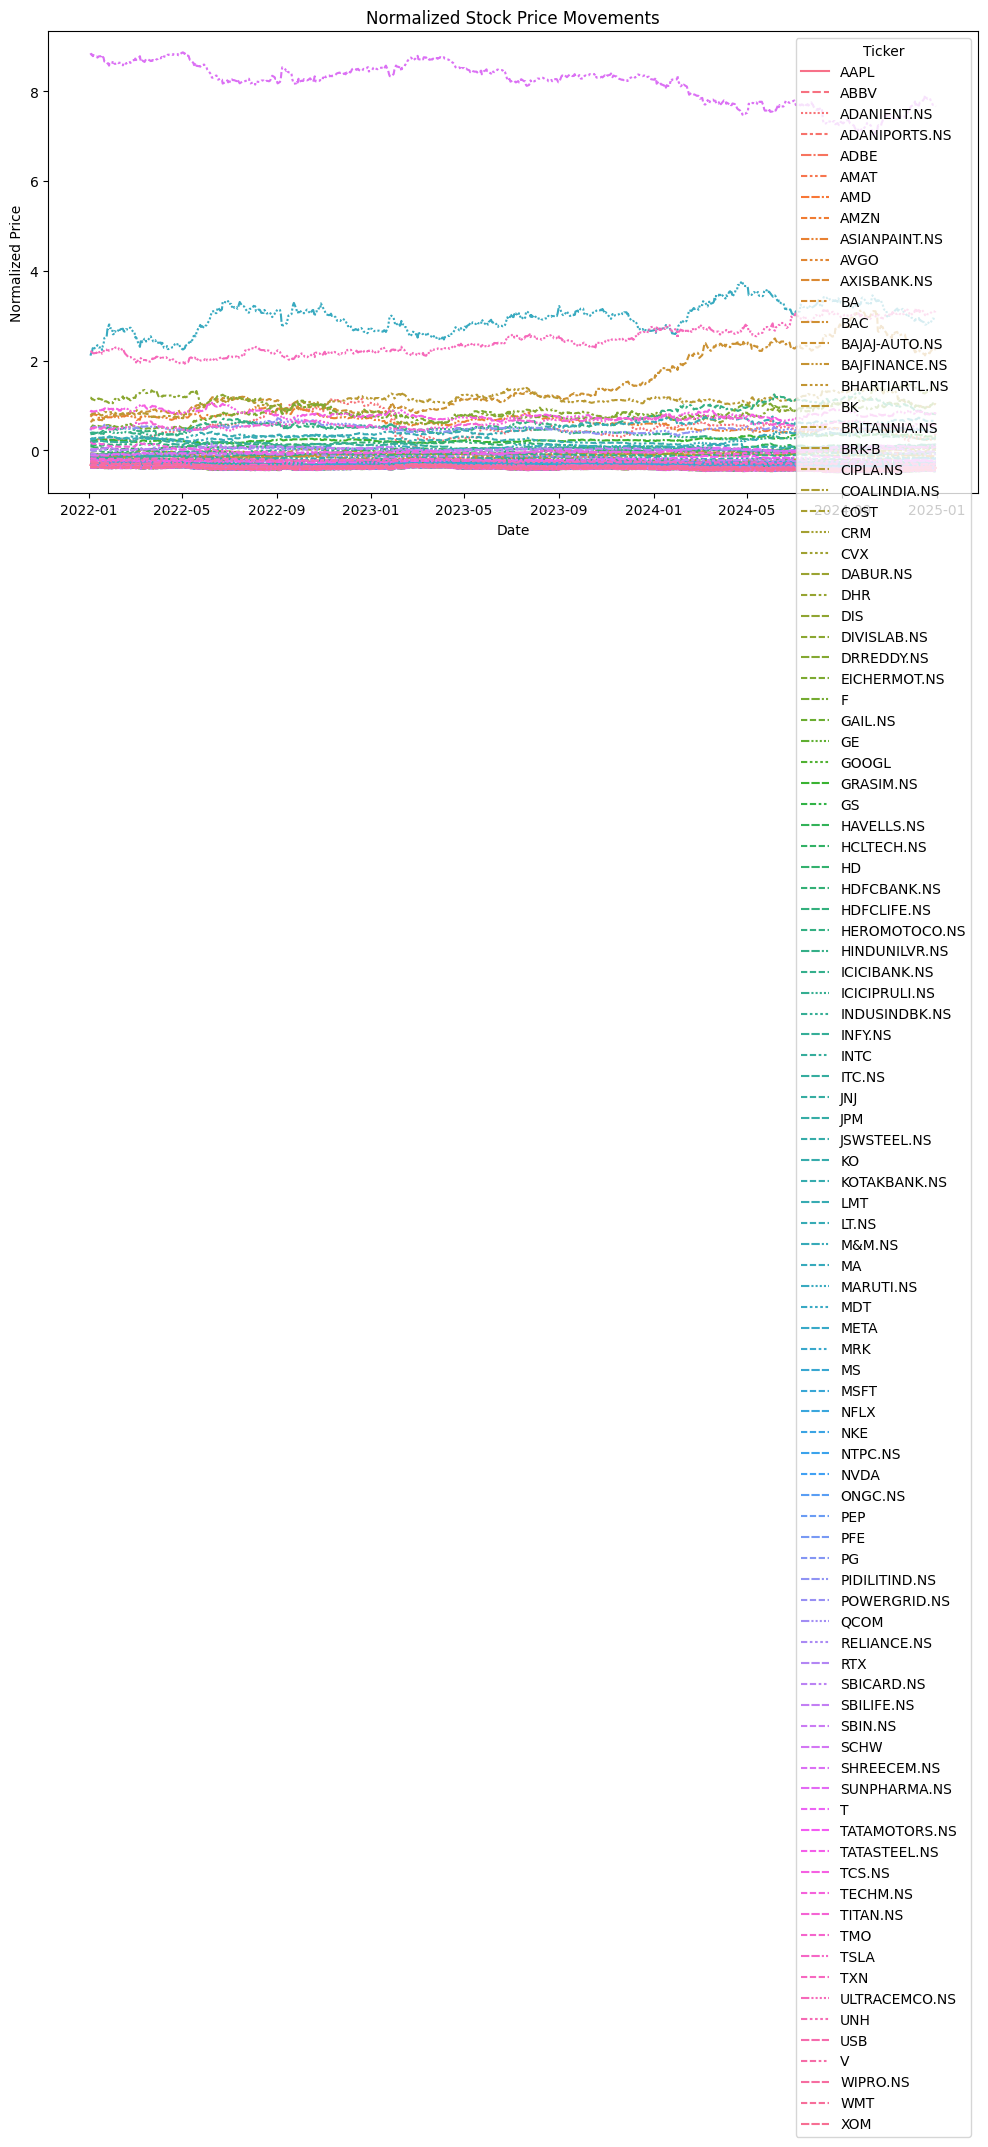

In [32]:
# Plot normalized stock prices
plt.figure(figsize=(12, 6))
sns.lineplot(data=normalized_df)
plt.title('Normalized Stock Price Movements')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.show()

## 4. Core ML: Dimensionality Reduction & Clustering

The high dimensionality of the time-series data (one feature per trading day) can be a challenge. We will use **Principal Component Analysis (PCA)** to reduce the number of features while retaining most of the variance.

Next, we will apply **K-Means Clustering**. To find the optimal number of clusters (`k`), we'll use the **Elbow Method**.

In [33]:
# Apply PCA
pca = PCA(n_components=0.95) # Retain 95% of variance
principal_components = pca.fit_transform(normalized_df.T)
print(f"Number of components selected: {pca.n_components_}")


Number of components selected: 1


In [34]:
pca = PCA(n_components=2) # Retain 95% of variance
principal_components = pca.fit_transform(normalized_df.T)
print(f"Number of components selected: {pca.n_components_}")

Number of components selected: 2


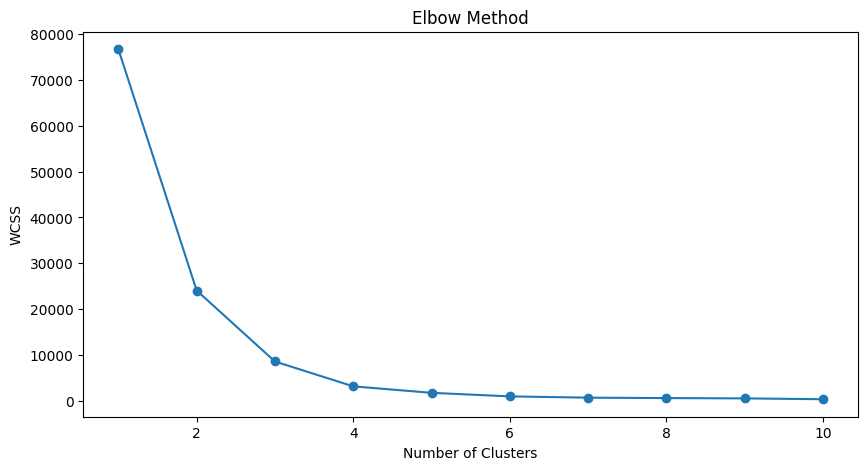

In [35]:
# Elbow Method to find optimal k
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(principal_components)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [38]:
# Based on the elbow plot,we choose k=4 and train the final model
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(principal_components)

## 5. Results & Visualization

The model has grouped the stocks into four distinct clusters. We can now visualize these clusters using the first two principal components.

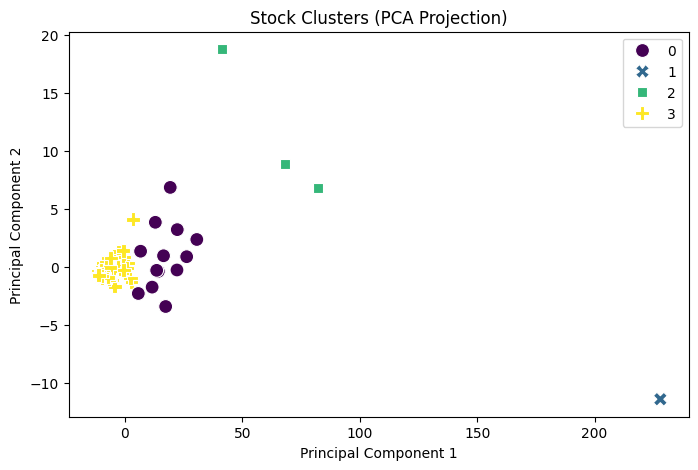

            Stock  Cluster
0            AAPL        3
1            ABBV        3
2     ADANIENT.NS        0
3   ADANIPORTS.NS        3
4            ADBE        3
..            ...      ...
94            USB        3
95              V        3
96       WIPRO.NS        3
97            WMT        3
98            XOM        3

[99 rows x 2 columns]


In [39]:
# Plot the clusters
plt.figure(figsize=(8, 5))
sns.scatterplot(x=principal_components[:, 0], y=principal_components[:, 1],hue=clusters, palette='viridis', style=clusters, s=100)
plt.title('Stock Clusters (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Add a table showing which stock belongs to which cluster
stock_clusters = pd.DataFrame({'Stock': data.columns, 'Cluster': clusters})
print(stock_clusters)